In [1]:
# import libraries 
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import glob
import pickle
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
class Hog_descriptor():
    def __init__(self, img, cell_size=16, bin_size=8):
        self.img = img
        self.img = np.sqrt(img / float(np.max(img)))
        self.img = self.img * 255
        self.cell_size = cell_size
# in slides, bin_size = 9 
        self.bin_size = bin_size
        self.angle_unit = 360 / self.bin_size
        assert type(self.bin_size) == int, "bin_size should be integer,"
        assert type(self.cell_size) == int, "cell_size should be integer,"
        #assert type(self.angle_unit) == int, "bin_size should be divisible by 360"

# Compute Gradients of hole image-patch, use sobel mask
    def global_gradient(self):
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
        gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
        return gradient_magnitude, gradient_angle

    def extract(self):
        height, width = self.img.shape
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)
        cell_gradient_vector = np.zeros((int(height / self.cell_size), int(width / self.cell_size), self.bin_size))
        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                                 j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                             j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)

        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)
        hog_vector = []
        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
                magnitude = mag(block_vector)
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)
        return hog_vector, hog_image

    def cell_gradient(self, cell_magnitude, cell_angle):
        orientation_centers = [0] * self.bin_size
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                gradient_strength = cell_magnitude[i][j]
                gradient_angle = cell_angle[i][j]
                min_angle, max_angle, mod = self.get_closest_bins(gradient_angle)
                orientation_centers[min_angle] += (gradient_strength * (1 - (mod / self.angle_unit)))
                orientation_centers[max_angle] += (gradient_strength * (mod / self.angle_unit))
        return orientation_centers

    def get_closest_bins(self, gradient_angle):
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        if idx == self.bin_size:
            return idx - 1, (idx) % self.bin_size, mod
        return idx, (idx + 1) % self.bin_size, mod

    def render_gradient(self, image, cell_gradient):
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                for magnitude in cell_grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * self.cell_size + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size - magnitude * cell_width * math.sin(angle_radian))
                    cv2.line(image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                    angle += angle_gap
        return image

In [3]:
#procedure for reading/processing data
def _preprocessing(fileType):
    data = []
    labels = []
    for path in glob.glob(fileType):
        _, brand, fn = path.split('\\')

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        hog = Hog_descriptor(img, cell_size=16, bin_size=16)
        vector, image = hog.extract()

        # update the data and labels
        data.append(vector)
        labels.append(brand)
    return data, labels

In [4]:
work_path = 'CarLogo/'
dataTrain, labelsTrain = _preprocessing(work_path + 'trainData/**/*.jpg')

In [5]:
def _save(path, obj):
    with open(path, 'wb') as fn:
        pickle.dump(obj, fn)

In [6]:
def _transform_data(data, labels):
    # Tạo input array X
    X = np.array(data)
    # Tạo output array y
    le = LabelEncoder()
    le.fit(labels)
    y = le.transform(labels)
    y_ind = np.unique(y)
    y_dict = dict(zip(y_ind, le.classes_))
    return X, y, y_dict, le

In [7]:
X_train, y_train, y_dict, le = _transform_data(dataTrain, labelsTrain) 

### processing test data 

In [8]:
work_path = 'CarLogo/'
dataTest, labelsTest = _preprocessing(work_path + 'testData/**/*.jpg')

In [9]:
X_test, y_test, y_dict, le = _transform_data(dataTest, labelsTest) 

In [10]:
size_Xtrain = X_train.shape
train =  X_train.reshape(size_Xtrain[0], (size_Xtrain[1]*size_Xtrain[2]))
size_Xtest = X_test.shape
test =  X_test.reshape(size_Xtest[0], (size_Xtest[1]*size_Xtest[2]))

In [11]:
clf = LogisticRegression(C=1e5, solver = 'lbfgs', multi_class = 'multinomial')
clf = LogisticRegression(random_state=0).fit(train, y_train)
y_pred = clf.predict(test)
print(f'Accuracy score softmax :  {accuracy_score(y_test,y_pred)}')      

Accuracy score softmax :  0.968


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Bài 3


In [12]:
#procedure for reading/processing data
def _preprocessing1(fileType):
    data = []
    imageOrigin = []
    for path in glob.glob(fileType):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        imageOrigin.append(img)
        img = cv2.resize(img, (100, 100))
        hog = Hog_descriptor(img, cell_size=16, bin_size=16)
        vector, image = hog.extract()

        # update the data and labels
        data.append(vector)
       
    return data, imageOrigin

In [13]:
work_path = 'Images/'
dataTrain, imgOrg = _preprocessing1('Images/data/*.jpg')

In [14]:
np.array(dataTrain).shape

(8091, 25, 64)

In [15]:
dataTrain = np.array(dataTrain)
data = np.reshape(dataTrain,(dataTrain.shape[0],dataTrain.shape[1]*dataTrain.shape[2]))

In [16]:
data.shape

(8091, 1600)

In [17]:
# a_file = open("test.txt", "w")
# for row in dataTrain:
#     np.savetxt(a_file, row)

# a_file.close()

In [18]:
def getCosinResponding(a,b):
    a = np.array(a)
    b = np.array(b)
    cosinAB = 0
    sumAB = 0
    sumA2 = 0
    sumB2 = 0
    for i in range(len(a)):
        sumAB += a[i]*b[i]
        sumA2 += a[i]*a[i]
        sumB2 += b[i]*b[i]
    sqr = math.sqrt(sumA2)*math.sqrt(sumB2)
    return  (sumAB / sqr)


In [19]:
def getRespondingImage(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (100, 100))
    hog = Hog_descriptor(img, cell_size=16, bin_size=16)
    vector, image = hog.extract()
    vector = np.array(vector)
    vect = np.reshape(vector,(1,vector.shape[1]*vector.shape[0])).T
    arrayCosin = []
    for i in data:
        arrayCosin.append(getCosinResponding(vect,i))
    return np.sort(arrayCosin)

In [20]:
result =  getRespondingImage("Images/datasamall/17273391_55cfc7d3d4.jpg")

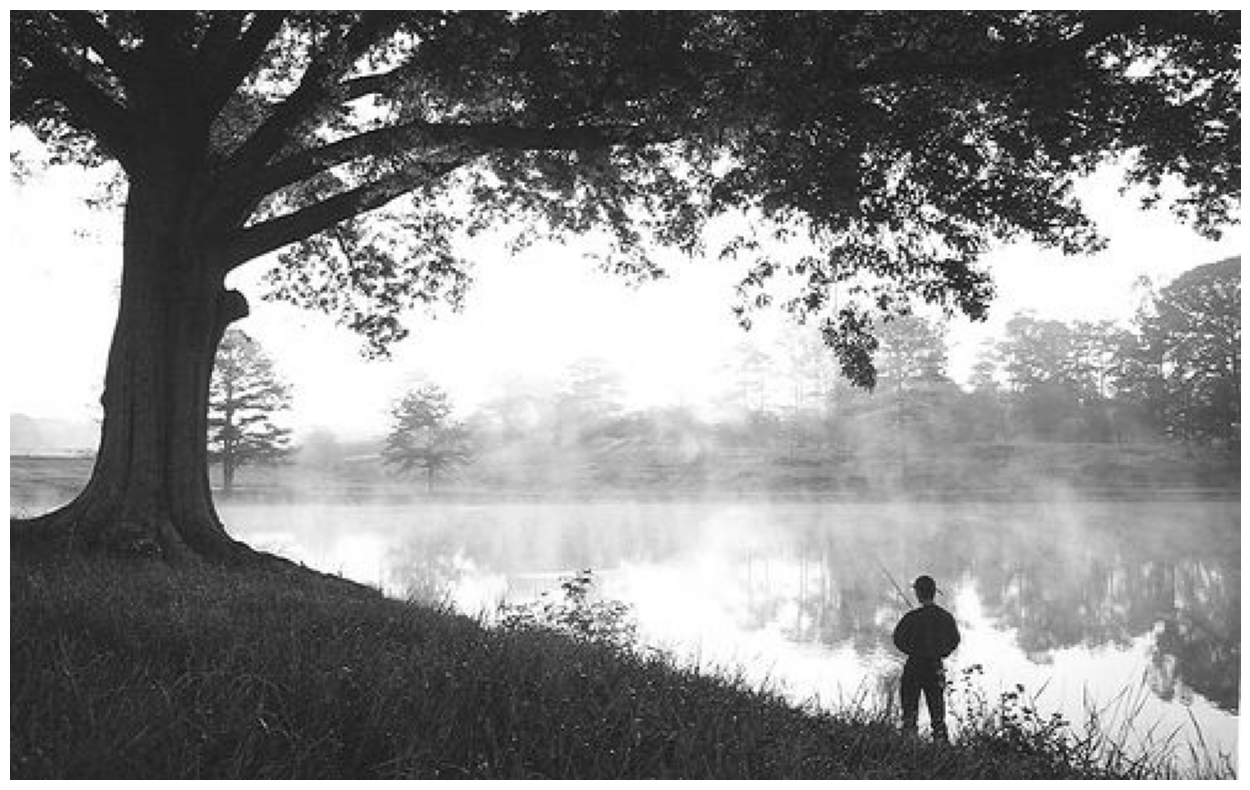

In [46]:
img = cv2.imread("Images/datasamall/17273391_55cfc7d3d4.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 10))
plt.imshow(img,cmap='viridis')
plt.axis("off")
plt.show()

In [21]:
my_dict = dict() 
for index,value in enumerate(result):
  my_dict[index] = value
dict_sort = {k: v for k, v in sorted(my_dict.items(), key=lambda item: item[1],reverse=True)} 

In [22]:
responImage = dict_sort.keys()
res_arry = list(responImage)


[684, 4633, 3751, 1164, 4099, 6459, 763, 773, 1516, 1103]

In [31]:
result = res_arry[0:10]
img_result = []
for i in range(10):
    imgTemp = cv2.resize(imgOrg[result[i]] , (240, 360))
    img_result.append(imgTemp)
    


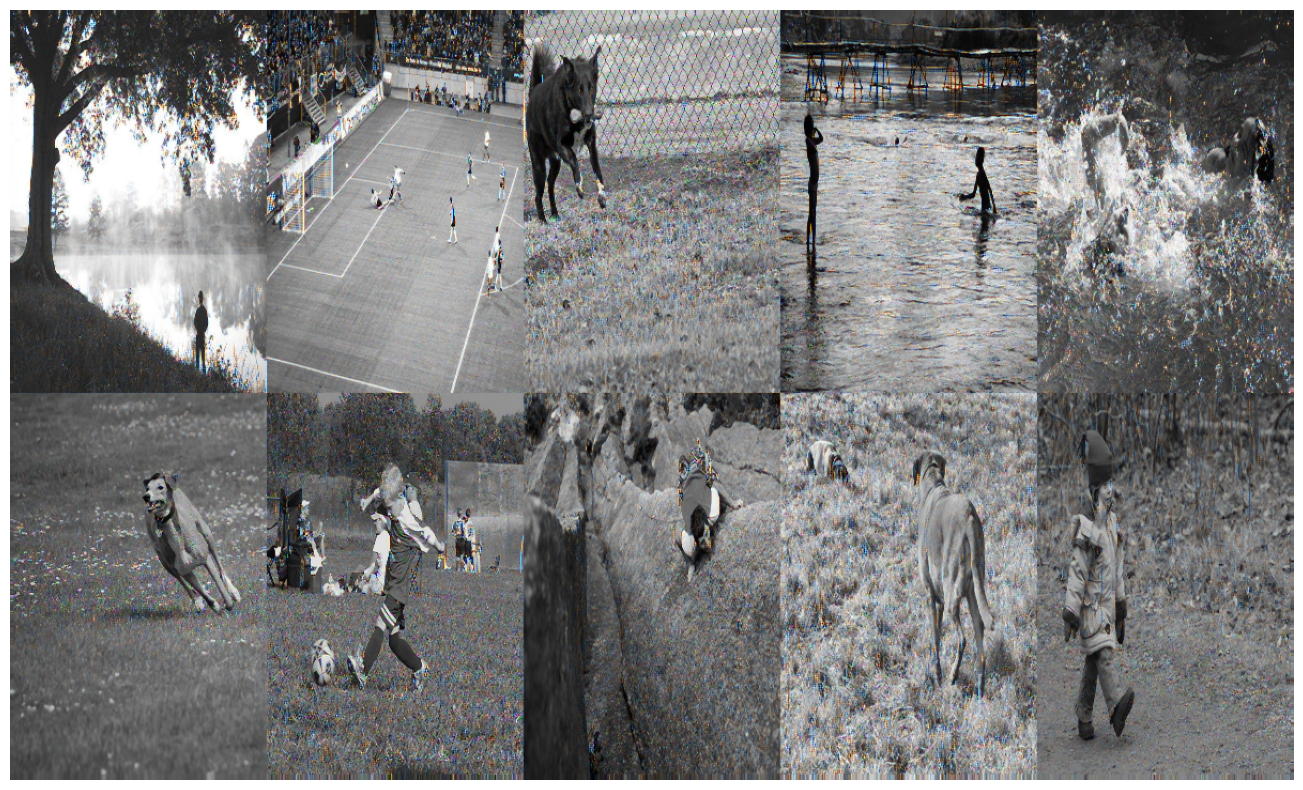

In [50]:
veticalImage1 = np.concatenate((img_result[0],img_result[1],img_result[2],img_result[3],img_result[4]),axis=1)
veticalImage2 = np.concatenate((img_result[5],img_result[6],img_result[7],img_result[8],img_result[9]),axis=1)
veticalImage = np.concatenate((veticalImage1,veticalImage2) ,axis=0)
veticalImage = cv2.cvtColor(veticalImage, cv2.COLOR_BayerGR2RGB_VNG)
# displaying image
plt.figure(figsize=(20, 10))
plt.imshow(veticalImage,cmap='viridis')
plt.axis("off")
plt.show()